# Implementation of the Quantum Pennylane Lambeq pipeline for MULTICLASS classification

Code based on the the Quantum transfer learning pennylane tutorial but adapted for an NLP use case.

\+ Based on the Quantum NLP with the lambeq–PennyLane integration tutorial

https://pennylane.ai/qml/demos/tutorial_quantum_transfer_learning

https://pennylane.ai/blog/2023/04/quantum-nlp-with-the-lambeq-pennylane-integration/


## Basic Imports

In [1]:
import os
import warnings
import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from torch.optim import lr_scheduler
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')
os.environ['TOKENIZERS_PARALLELISM'] = 'true'

In [2]:
import numpy as np
import torch

## Seed everything for reproductibility

In [3]:
def seed_everything(seed: int):
    import random, os
    import numpy as np
    import torch
    
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    torch.mps.manual_seed(seed)


In [4]:
seed_everything(0)

## Setting of the main hyper-parameters of the model

In [5]:
N_CLASSES = 5 # number of classes in the dataset

# ansatz(remove_cups(diagram)) works only for n_qubits as a int and not as a np.int64 --> Thats why we use .item()
n_qubits = np.ceil(np.log2(N_CLASSES)).astype(int).item() # number of qubits required to represent the classes
n_qubits

3

In [6]:
BATCH_SIZE = 2048
EPOCHS = 50
LR = 2e-1
GAMMA_LR = 0.5    # Learning rate reduction applied every STEP_LR epochs.
STEP_LR = 20
WEIGHT_DECAY = 2e-2

## Inputting the data

The dataset is created from 2 CSV file of size (80, 3) and (20, 3) respectively.

Each example has 3 features: Class, Sentence, Sentence_Embedding

In [8]:
def preprocess_train_test_dataset(train_csv_file, test_csv_file):
    """
    Preprocess function for the dataset + Create train/test split
    """
    df_train = pd.read_csv(train_csv_file)
    df_test = pd.read_csv(test_csv_file)


    df_train['sentence_embedding'] = np.array([np.fromstring(embedding.strip(' []'), sep=',') for embedding in df_train['sentence_embedding']]).tolist()
    df_test['sentence_embedding'] = np.array([np.fromstring(embedding.strip(' []'), sep=',') for embedding in df_test['sentence_embedding']]).tolist()

    #Preprocess labels
    label_encoder = preprocessing.LabelEncoder()
    label_encoder.fit(df_train['class'].append(df_test['class']))

    df_train['class'] = label_encoder.transform(df_train['class'])
    df_test['class'] = label_encoder.transform(df_test['class'])



    X_train, y_train, X_test, y_test = df_train[['sentence_embedding', 'sentence']], df_train['class'], df_test[['sentence_embedding', 'sentence']], df_test['class']

    return X_train, X_test, y_train, y_test

In [9]:
X_train, X_test, y_train, y_test = preprocess_train_test_dataset('../../../../../data/toy_dataset/toy_dataset_multiclass_bert_sentences_train.csv', '../../../../../data/toy_dataset/toy_dataset_multiclass_bert_sentences_test.csv')

## Creating and parameterizing diagrams

In [11]:
from lambeq import BobcatParser

parser = BobcatParser(verbose='text')

raw_train_diagrams = parser.sentences2diagrams(X_train['sentence'].values.tolist(), suppress_exceptions=True)
raw_val_diagrams = parser.sentences2diagrams(X_test['sentence'].values.tolist(), suppress_exceptions=True)

Tagging sentences.
Parsing tagged sentences.
Turning parse trees to diagrams.
Tagging sentences.
Parsing tagged sentences.
Turning parse trees to diagrams.


In [12]:
from lambeq import Rewriter
# Apply rewrite rule for prepositional phrases
# Here we use try and except to avoid errors when the parser fails to parse a sentence (occurs only for the 21k dataset)

rewriter = Rewriter(['prepositional_phrase', 'determiner', 'curry'])

raw_train_diagrams_rewrited = []
raw_val_diagrams_rewrited = []
y_train_rewrited = []
y_test_rewrited = []

for index, diagram in enumerate(raw_train_diagrams):
    try:
        raw_train_diagrams_rewrited.append(rewriter(diagram))
        y_train_rewrited.append(y_train.iloc[index])
    except TypeError:
       print(index)


print('Train size: ', len(raw_train_diagrams_rewrited))

for index, diagram in enumerate(raw_val_diagrams):
    try:
        raw_val_diagrams_rewrited.append(rewriter(diagram))
        y_test_rewrited.append(y_test.iloc[index])
    except TypeError:
        print(index)

print('Test size: ', len(raw_val_diagrams_rewrited))

Train size:  80
Test size:  20


In [13]:
raw_train_diagrams = raw_train_diagrams_rewrited
raw_val_diagrams = raw_val_diagrams_rewrited
y_train = y_train_rewrited
y_test = y_test_rewrited

In [14]:
train_diagrams = [
    diagram.normal_form()
    for diagram in raw_train_diagrams if diagram is not None
]
val_diagrams = [
    diagram.normal_form()
    for diagram in raw_val_diagrams if diagram is not None
]

train_labels = [
    label for (diagram, label)
    in zip(raw_train_diagrams, y_train)
    if diagram is not None]
val_labels = [
    label for (diagram, label)
    in zip(raw_val_diagrams, y_test)
    if diagram is not None
]

## Creating circuits

In [15]:
from lambeq import AtomicType, IQPAnsatz, remove_cups

ansatz = IQPAnsatz({AtomicType.NOUN: 1, AtomicType.SENTENCE: n_qubits},
                   n_layers=4, n_single_qubit_params=3)

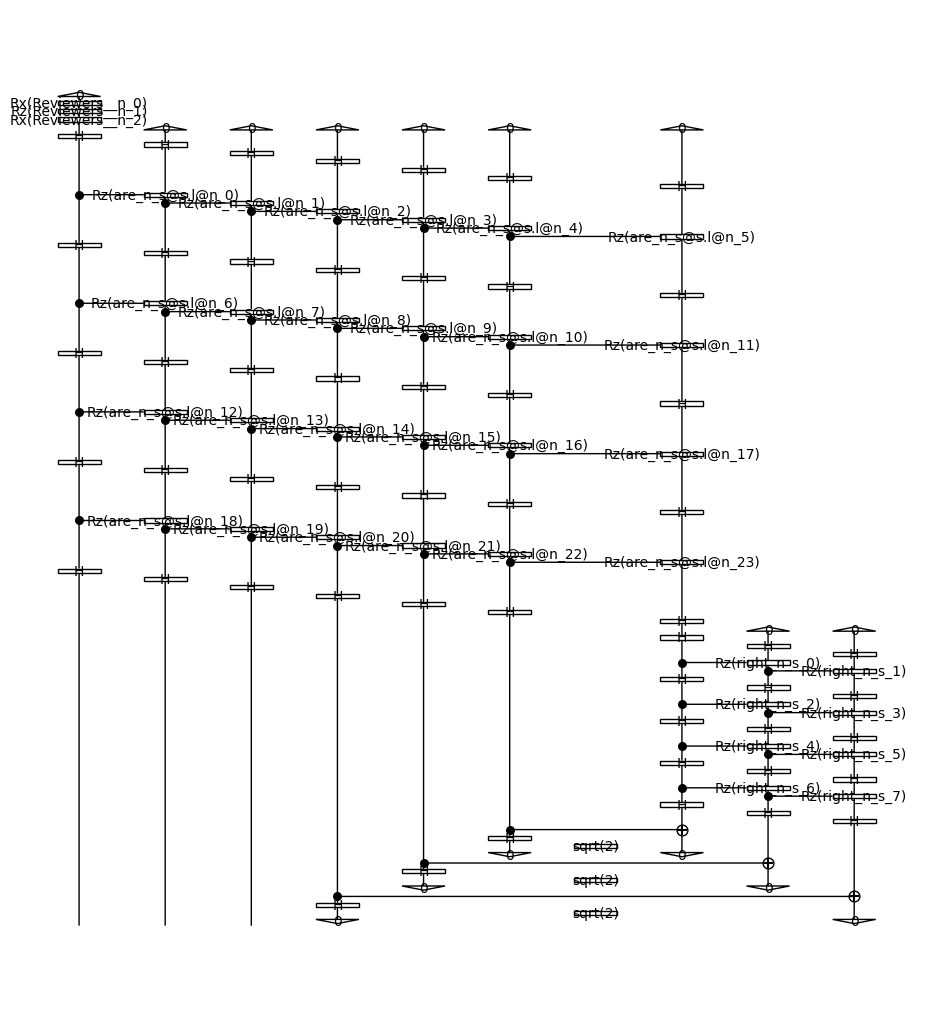

In [16]:
train_circuits = [ansatz(remove_cups(diagram)) for diagram in train_diagrams]
val_circuits =  [ansatz(remove_cups(diagram))  for diagram in val_diagrams]

train_circuits[0].draw(figsize=(9, 10))

## Hybrid QNLP Model

In [17]:
from torch import nn
from lambeq import PennyLaneModel

# inherit from PennyLaneModel to use the PennyLane circuit evaluation
class DressedQuantumModel(PennyLaneModel):
    def __init__(self, **kwargs):
        PennyLaneModel.__init__(self, **kwargs)

        self.pre_qc_output_size = None

        self.pre_qc = None

        self.param_indexes_dict = {}
        
    
    # To be called after the model is initialized
    ##############################################################################################################
    def update_pre_qc_output_size(self):
        """
        Find the output size of the pre_qc neural network + Create the pre_qc neural network.
        """
        self.pre_qc_output_size = self.find_pre_qc_output_size()
        self.pre_qc = nn.Sequential(nn.Linear(768, self.pre_qc_output_size),
                                    nn.LeakyReLU(0.01))

    def find_pre_qc_output_size(self):
        """
        Find the output size of the pre_qc neural network.
        It is the maximum number of parameters in all the circuits.
        """
        max_number_of_params = 0
        for circuit_pennylane in list(self.circuit_map.values()):
            if circuit_pennylane._symbols.__len__() > max_number_of_params:
                max_number_of_params = circuit_pennylane._symbols.__len__()

        return max_number_of_params
    
    def find_param_indexes_from_diagram_dict(self, diagrams):
        """
        Given a diagram, find the indexes of the parameters in the model.
        Do it once and for all in the init function
        Return a dictionary with the diagram as key and the list of indexes as value.
        """
        for diagram in diagrams:
            diagram_symbols = self.circuit_map[diagram]._symbols
            model_symbols = self.symbols

            param_indexes = []

            for symbol in diagram_symbols:
                try:
                    param_indexes.append(model_symbols.index(symbol))
                except ValueError:
                    print(f"Symbol {symbol} not found in model symbols")
                    return None
                
            self.param_indexes_dict[diagram] = param_indexes
    ##############################################################################################################    
    

    def update_weights_from_embedding(self, param_indexes, param_values):
        """
        Given a list of indexes and a list of values, update the weights of the model
        """
        for index, value in zip(param_indexes, param_values):
            self.weights[index] = torch.nn.Parameter(torch.tensor(value))


    def forward(self, diagrams, bert_embeddings):
        ## Here we go through lists of diagrams and bert embeddings because the Pytorch dataloader returns lists (uses batch)
        # pass the embedding through a simple neural network
        embedding_out = self.pre_qc(bert_embeddings)

        # update the corresponding weights of the model
        param_indexes_list = [self.param_indexes_dict[diagram] for diagram in diagrams]

        # update the weights of the model
        [self.update_weights_from_embedding(param_indexes, embedding) for param_indexes, embedding in zip(param_indexes_list, embedding_out)]

        # evaluate the circuits
        qc_output = self.get_diagram_output(diagrams)

        # flatten the output to have (batch_size, n_qubits*2)
        qc_output = qc_output.flatten(start_dim=1)

        # keep only the first N_CLASSES
        qc_output = qc_output[:, 0:N_CLASSES]

        return qc_output


### Creating the train/valid datasets

In [18]:
all_circuits = train_circuits + val_circuits

In [19]:
from lambeq import Dataset

# initialise datasets and optimizers as in PyTorch
train_dataset = Dataset(list(zip(train_circuits, np.vstack(X_train['sentence_embedding'].apply(np.array)))),
                        train_labels,
                        batch_size=BATCH_SIZE)

valid_dataset = Dataset(list(zip(val_circuits, np.vstack(X_test['sentence_embedding'].apply(np.array)))),
                        val_labels,
                        batch_size=BATCH_SIZE)


### Initializing the model

In [20]:
model = DressedQuantumModel.from_diagrams(all_circuits, probabilities=True, normalize=True)
# initialise our model by pas sing in the diagrams, so that we have trainable parameters for each token
model.initialise_weights()
model.update_pre_qc_output_size()
model.find_param_indexes_from_diagram_dict(all_circuits)
model = model.double()

In [21]:
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
exp_lr_scheduler = lr_scheduler.StepLR(
    optimizer, step_size=STEP_LR, gamma=GAMMA_LR
)

### Initializing Tensorboard to log our results

In [22]:
from torch.utils.tensorboard import SummaryWriter
import datetime

#log_dir = "logs/fit_pennylane_lambeq_V2/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
log_dir = "logs/fit_pennylane_lambeq_multiclass/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

summary_writer = SummaryWriter(log_dir=log_dir)

### Training loop

In [23]:
best = {'acc': 0, 'epoch': 0}
best_val_loss = 1000
best_val_acc = 0
best_train_loss = 1000
best_acc_train = 0

training_loss_list = []
validation_loss_list = []
training_acc_list = []
validation_acc_list = []

for epoch in range(EPOCHS):
    print('Epoch: {}'.format(epoch))
    running_loss = 0.0
    running_corrects = 0

    model.train()
    #for circuits, embeddings, labels in train_dataloader:
    for input, labels in train_dataset:
        batch_size_ = len(input)

        labels = torch.from_numpy(labels).long()
        circuits, embeddings = np.array(input).T
        optimizer.zero_grad()
        outputs = model(circuits, torch.from_numpy(np.vstack(embeddings)))

        _, preds = torch.max(outputs, 1)

        # use CELoss as our outputs are probabilities
        loss = criterion(outputs, labels)
        #running_loss += loss.item()
        running_loss += loss.item()*batch_size_
        loss.backward()
        optimizer.step()

        batch_corrects = torch.sum(preds == labels).item()
        running_corrects += batch_corrects
        


    # Print epoch results
    train_loss = running_loss / len(train_dataset)
    train_acc = running_corrects / len(train_dataset)
    

    summary_writer.add_scalar("Training/Loss", train_loss, epoch)
    summary_writer.add_scalar("Training/Acurracy", train_acc, epoch)

    training_loss_list.append(train_loss)
    training_acc_list.append(train_acc)


    if train_loss < best_train_loss:
        best_train_loss = train_loss

    if train_acc > best_acc_train:
        best_acc_train = train_acc

    running_loss = 0.0
    running_corrects = 0

    model.eval()

    # evaluate on valid set every 5 epochs
    # save the model if it's the best so far
    # stop training if the model hasn't improved for 10 epochs
    with torch.no_grad():
        for input, labels in valid_dataset:
            batch_size_ = len(input)

            labels = torch.from_numpy(labels).long()
            circuits, embeddings = np.array(input).T
            optimizer.zero_grad()
            outputs = model(circuits, torch.from_numpy(np.vstack(embeddings)))

            _, preds = torch.max(outputs, 1)

            # use CELoss as our outputs are probabilities
            loss = criterion(outputs, labels)

            loss = criterion(outputs, labels)
            running_loss += loss.item()*batch_size_


            batch_corrects = torch.sum(preds == labels).item()
            running_corrects += batch_corrects


    validation_loss = running_loss / len(valid_dataset)
    validation_acc = running_corrects / len(valid_dataset)

    summary_writer.add_scalar("Validation/Loss", validation_loss, epoch)
    summary_writer.add_scalar("Validation/Acurracy", validation_acc, epoch)

    validation_loss_list.append(validation_loss)
    validation_acc_list.append(validation_acc)

    exp_lr_scheduler.step()
    
    print('Train loss: {}'.format(train_loss))
    print('Valid loss: {}'.format(validation_loss))
    print('Train acc: {}'.format(train_acc))
    print('Valid acc: {}'.format(validation_acc))

    if validation_acc > best_val_acc:
            best_val_acc = validation_acc
            best['epoch'] = epoch
            model.save('nlp_dressed_alpha_model.lt')



    if validation_loss < best_val_loss:
        best_val_loss = validation_loss




Train loss: 1.6009467390706837
Valid loss: 1.640058243585176
Train acc: 0.25
Valid acc: 0.1
Epoch: 4
Train loss: 1.6045663010411566
Valid loss: 1.624577911732807
Train acc: 0.2625
Valid acc: 0.15
Epoch: 5
Train loss: 1.586396302083633
Valid loss: 1.6295971551448638
Train acc: 0.3
Valid acc: 0.05
Epoch: 6
Train loss: 1.5801544767956517
Valid loss: 1.6166430893364083
Train acc: 0.35
Valid acc: 0.15
Epoch: 7
Train loss: 1.5462857510759762
Valid loss: 1.6050144693260904
Train acc: 0.45
Valid acc: 0.15
Epoch: 8
Train loss: 1.496882624662536
Valid loss: 1.6281831138533238
Train acc: 0.5125
Valid acc: 0.15
Epoch: 9
Train loss: 1.4716969293027842
Valid loss: 1.6438765776049848
Train acc: 0.575
Valid acc: 0.15
Epoch: 10
Train loss: 1.4319071101875283
Valid loss: 1.6597563694614723
Train acc: 0.65
Valid acc: 0.05
Epoch: 11
Train loss: 1.4044754951782195
Valid loss: 1.665398854363214
Train acc: 0.7375
Valid acc: 0.0
Epoch: 12
Train loss: 1.3874512791625788
Valid loss: 1.6527729608699384
Train acc

In [24]:
summary_writer.add_hparams({'lr': LR, 'gamma_lr': GAMMA_LR, 'step_lr': STEP_LR, 'weight_decay': WEIGHT_DECAY},
                      {'hparam/loss_train': best_train_loss, 'hparam/acc_train': best_acc_train,
                       'hparam/loss_valid': best_val_loss, 'hparam/acc_valid': best_val_acc})

## Display loss and accuracy results

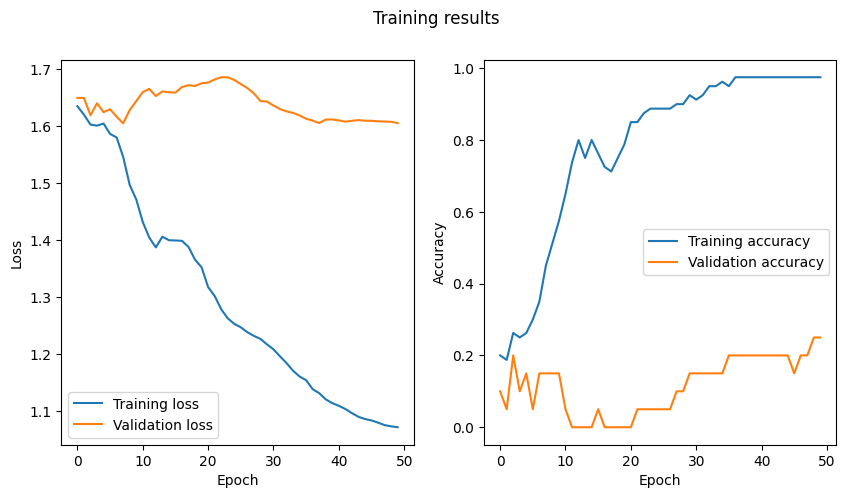

In [25]:
fig, ax1 = plt.subplots(1,2)

# Plot Training and Validation Loss
ax1[0].plot(training_loss_list, label='Training loss')
ax1[0].plot(validation_loss_list, label='Validation loss')
ax1[0].legend()
ax1[0].set_ylabel('Loss')
ax1[0].set_xlabel('Epoch')

# Plot Training and Validation Accuracy
ax1[1].plot(training_acc_list, label='Training accuracy')
ax1[1].plot(validation_acc_list, label='Validation accuracy')
ax1[1].legend()
ax1[1].set_ylabel('Accuracy')
ax1[1].set_xlabel('Epoch')


fig.suptitle('Training results')
fig.set_size_inches(10, 5)